# California Algorithm Anomaly Detection

In [1]:
import torch
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datautils import get_morning_data, get_gcnae_sequence, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_gcnae, compute_anomaly_threshold_gcnae, test_model, threshold_anomalies, fill_result_df, test_gcnae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc
import torch.nn as nn
from tqdm import tqdm

import random
import os

/home/austinc/.conda/envs/traffic-anomaly/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
def california(state, uocc, docc):
    T1 = 8.1
    T2 = 0.313
    T3 = 16.8

    occdf = uocc - docc
    occrdf = occdf / (uocc + 1e-6)
    
    if state >= 1:
        if state >= 2:
            if occrdf >= T2:
                return 3
            return 0
        if occrdf >= T2:
            return 2
        return 0
    
    if occdf >= T1:
        if occrdf >= T2:
            if docc >= T3:
                return 0
            return 1
        return 0
    return 0

In [45]:
_, test_data, _ = get_full_data()
test_data = label_anomalies(test_data)

/home/austinc/projects/freeway-anomaly-detection/code/datautils.py:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[(data['unix_time'] - human_label_time <= 7200) & (data['unix_time'] - human_label_time >= 0), 'anomaly'] = 1
/home/austinc/projects/freeway-anomaly-detection/code/datautils.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.fillna(0, inplace=True)


In [5]:
# Whether a crash was reported at each time
crash_reported = test_data['crash_record'].to_numpy()[0::196]

In [29]:
def run_california(dataset, num_milemarkers):
    lanes = [1, 2, 3, 4]
    # Run for each lane independently
    full_results = []
    for lane_num in tqdm(lanes):
        lane_data = dataset[lane_num-1::len(lanes)]
        # For each lane, run the algorithm for each milemarker
        lane_anomaly = []
        # First and last milemarkers do not have any upstream/downstream, so always say not anomaly
        lane_anomaly.append([0]*len(lane_data[0::num_milemarkers]))
        for milemarker_no in range(1, num_milemarkers-1):
            # For each milemarker, we need to iterate over all available times
            upstream_data = lane_data[milemarker_no+1::num_milemarkers]
            downstream_data = lane_data[milemarker_no-1::num_milemarkers]
            state = 0
            milemarker_anomaly = []
            for (upstream_index, upstream), (downstream_index, downstream) in zip(upstream_data.iterrows(), downstream_data.iterrows()):
                if upstream['day'] != downstream['day']:
                    state = 0
                else:
                    state = california(state, upstream['occ'], downstream['occ'])
                
                milemarker_anomaly.append(state)

            lane_anomaly.append(milemarker_anomaly)
        
        lane_anomaly.append([0]*len(lane_data[0::num_milemarkers]))
        # lane_anomaly is [num_milemarkers, num_times]

        full_results.append(lane_anomaly)
    
    # full_results is [num_lanes, num_milemarkers, num_times] 
    # we want it as [num_times, num_nodes] where num_nodes = num_lanes * num_milemarkers
    # however, the ordering is important. It should be ordered by lane first, then milemarker (lane1_mm1, lane2_mm1, lane3_mm1, ...)
    transposed = np.transpose(full_results, (2, 0, 1))  # Shape becomes [num_times, num_lanes, num_milemarkers]

    # Reshape the array to flatten the last two dimensions
    reshaped = transposed.reshape(transposed.shape[0], -1)  # Shape becomes [num_times, num_nodes]

    return reshaped

In [31]:
california_results = run_california(test_data.reset_index(), 49)

100%|██████████| 4/4 [00:37<00:00,  9.46s/it]


In [32]:
california_results.shape

(4800, 196)

In [37]:
anomalies = (california_results > 0).astype(int)

In [38]:
anomalies.shape

(4800, 196)

In [40]:
crash_reported.shape

(4800,)

In [ ]:
def crash_detection_delay(anomaly_pred, crash_reported, sr=0.5):
    time_anomalies = np.any(anomaly_pred==1, axis=1)
    delay = []
    detects = []
    
    reported_indices = np.where(crash_reported == 1)[0]
    for i in reported_indices:
        detected = False
        for t in range(int(i-(15/sr)), int(i+(15/sr))):
            if t >= len(time_anomalies):
                detected = False
                break
            if time_anomalies[t] == 1:
                delay.append(t-i)
                detected = True
                break
            
        detects.append(detected)
    
    return delay, detects

In [41]:
delay, detects = crash_detection_delay(anomalies, crash_reported)

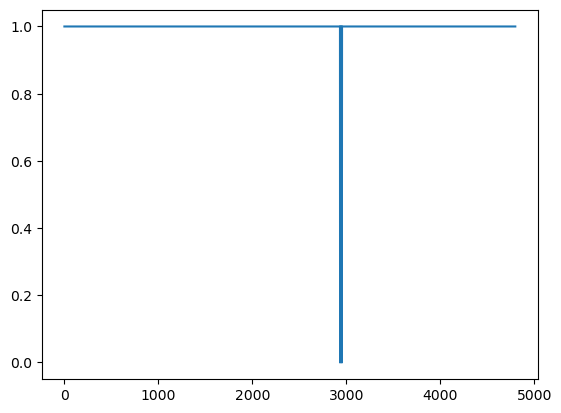

In [49]:
plt.plot(np.any(anomalies==1, axis=1))

In [64]:
print(np.mean(delay) / 2)
print(np.std(delay) / 2)
print(np.mean(detects))

-15.0
0.0
1.0


In [61]:
from sklearn.metrics import confusion_matrix


# Compute the confusion matrix
tn, fp, fn, tp = confusion_matrix(test_data['anomaly'].to_numpy()[::196], np.any(anomalies==1, axis=1)).ravel()

# Calculate FPR
fpr = fp / (fp + tn)

print(f"False Positive Rate (FPR): {fpr}")


False Positive Rate (FPR): 0.9990942028985508


Note that this is the time-level false positive rate. This is what is used for detection delay calculation. The node level false positive rate is below. If we knew where anomalies occurred, we could compute a more reliable detection delay.

In [63]:
from sklearn.metrics import confusion_matrix


# Compute the confusion matrix
tn, fp, fn, tp = confusion_matrix(test_data['anomaly'].to_numpy(), anomalies.flatten()).ravel()

# Calculate FPR
fpr = fp / (fp + tn)

print(f"False Positive Rate (FPR): {fpr}")


False Positive Rate (FPR): 0.07999667258207631
